# Rescue Drone Mission II - Backward Smoothing

Refine the trajectory estimates of a raft using a backward smoothing algorithm and compare its performance against a standard forward Kalman filter.

## 1. System and Simulation Parameters

In [44]:
import numpy as np
import matplotlib.pyplot as plt

N = 200
T = 1.0
M = 500

sigma_a_sq = 0.2**2

Phi = np.array([[1, T],
                [0, 1]])
G = np.array([[T**2 / 2],
              [T]])
Q = G @ G.T * sigma_a_sq
H = np.array([[1, 0]])
sigma_eta_val_sq = 20.0 ** 2
Ri = np.array([[sigma_eta_val_sq]])

x1_true = 5.0
v1_true = 1.0
X1_true = np.array([[x1_true], [v1_true]])

X0_0 = np.array([[x1_true], [v1_true]])
P0_0 = np.array([[10.0, 0], [0, 10.0]])

## 2. Trajectory and Measurement Generation

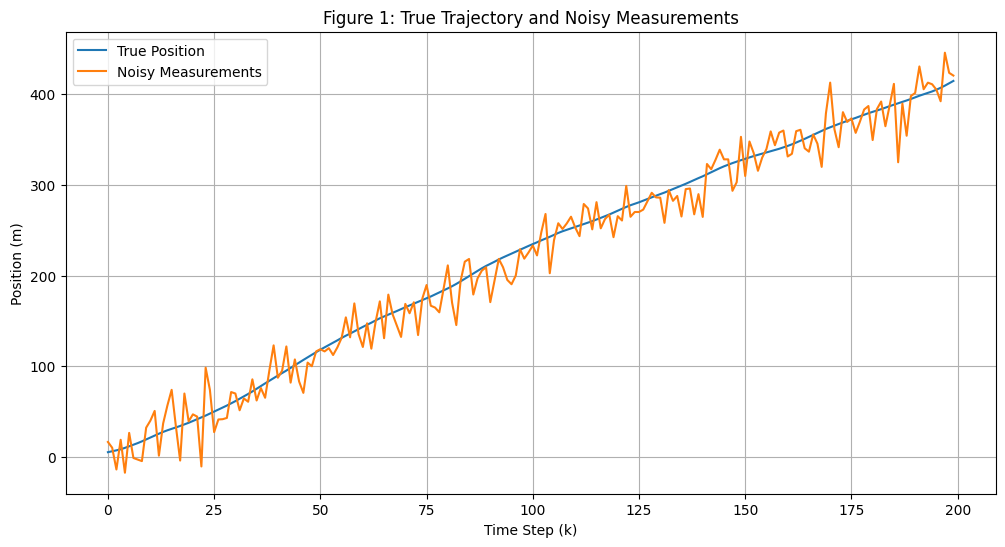

In [45]:
def generate_trajectory_and_measurements(N, X1_true, Phi, G, H, sigma_a_sq, R):
    X_true = np.zeros((N, 2, 1))
    z = np.zeros((N, 1, 1))
    
    X_true[0] = X1_true
    
    v = np.random.normal(0, np.sqrt(R), N)
    z[0] = H @ X_true[0] + v[0]
    
    a = np.random.normal(0, np.sqrt(sigma_a_sq), N)

    for i in range(1, N):
        X_true[i] = Phi @ X_true[i-1] + G * a[i]
        z[i] = H @ X_true[i] + v[i]
        
    return X_true, z

X_true, z= generate_trajectory_and_measurements(N, X1_true, Phi, G, H, sigma_a_sq, sigma_eta_val_sq)

plt.figure(figsize=(12, 6))
plt.plot(X_true[:, 0], label='True Position')
plt.plot(z[:, 0], label='Noisy Measurements')
plt.title('Figure 1: True Trajectory and Noisy Measurements')
plt.xlabel('Time Step (k)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Forward Kalman Filter

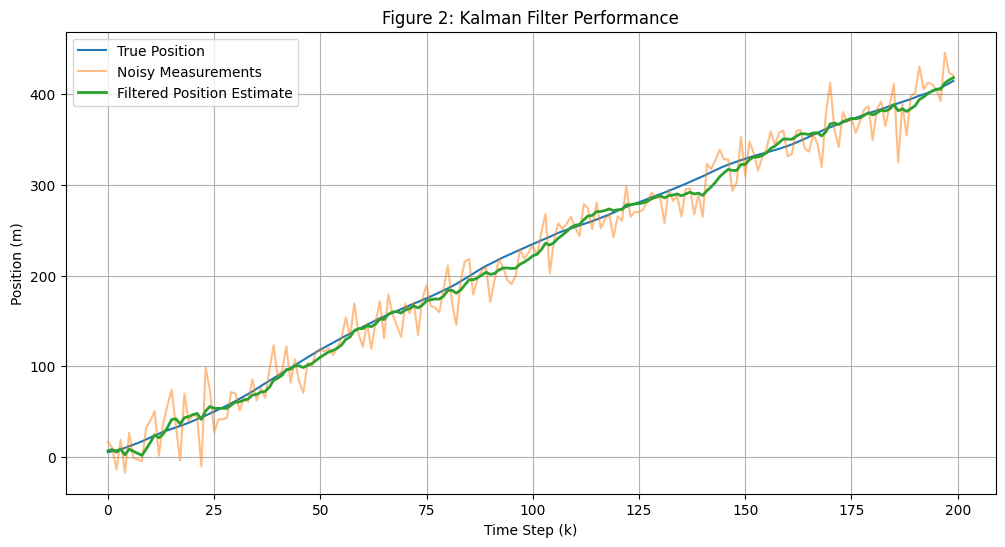

In [46]:
def run_kalman_filter(z, N, sigma_a_sq, X0_0, P0_0):
    Q = G @ G.T * sigma_a_sq
    X_filt_prev = X0_0
    P_filt_prev = P0_0

    X_predicted = np.zeros((N, 2, 1))
    P_predicted = np.zeros((N, 2, 2))
    X_filtered = np.zeros((N, 2, 1))
    P_filtered = np.zeros((N, 2, 2))

    K_history = np.zeros((N, 2, 1))

    for i in range(N):
        # prediction stage
        X_pred = Phi @ X_filt_prev

        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        # filtration stage
        residual = z[i] - H @ X_pred
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + Ri)
        X_filt = X_pred + K @ residual
        I = np.eye(2)
        P_filt = (I - K @ H) @ P_pred

        # save data
        X_predicted[i], P_predicted[i] = X_pred, P_pred
        X_filtered[i], P_filtered[i] = X_filt, P_filt
        K_history[i] = K
            
        X_filt_prev, P_filt_prev = X_filt, P_filt
    
    return X_filtered, P_filtered, X_predicted, P_predicted, K_history

X_filtered, P_filtered, X_predicted, P_predicted, _ = run_kalman_filter(z, N, sigma_a_sq, X0_0, P0_0)

plt.figure(figsize=(12, 6))
plt.plot(X_true[:, 0], label='True Position')
plt.plot(z[:, 0], alpha=0.5, label='Noisy Measurements')
plt.plot(X_filtered[:, 0], lw=2, label='Filtered Position Estimate')
plt.title('Figure 2: Kalman Filter Performance')
plt.xlabel('Time Step (k)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

## 4. Backward Smoothing

Backward smoother starts from the last estimate provided by the Kalman filter and moves backward in time, re-evaluating each state estimate using information from all subsequent measurements. This post-processing step improves the accuracy of the entire trajectory estimate.

The smoother algorithm is defined by the following recurrent equations, which are applied from `k = N-1` down to `0`:

- **Smoother Coefficient:** $ A_k = P\_filtered_{k} @ Phi.T @ inv(P\_predicted_{k+1}) $ 
- **Smoothed State:** $ X\_smoothed_{k} = X\_filtered_{k} + A_k @ (X\_smoothed_{k+1} - X\_predicted_{k+1}) $
- **Smoothed Covariance:** $ P\_smoothed_k = P\_filtered_k + A_k @ (P\_smoothed_{k+1} - P\_predicted_{k+1}) @ A_k.T $

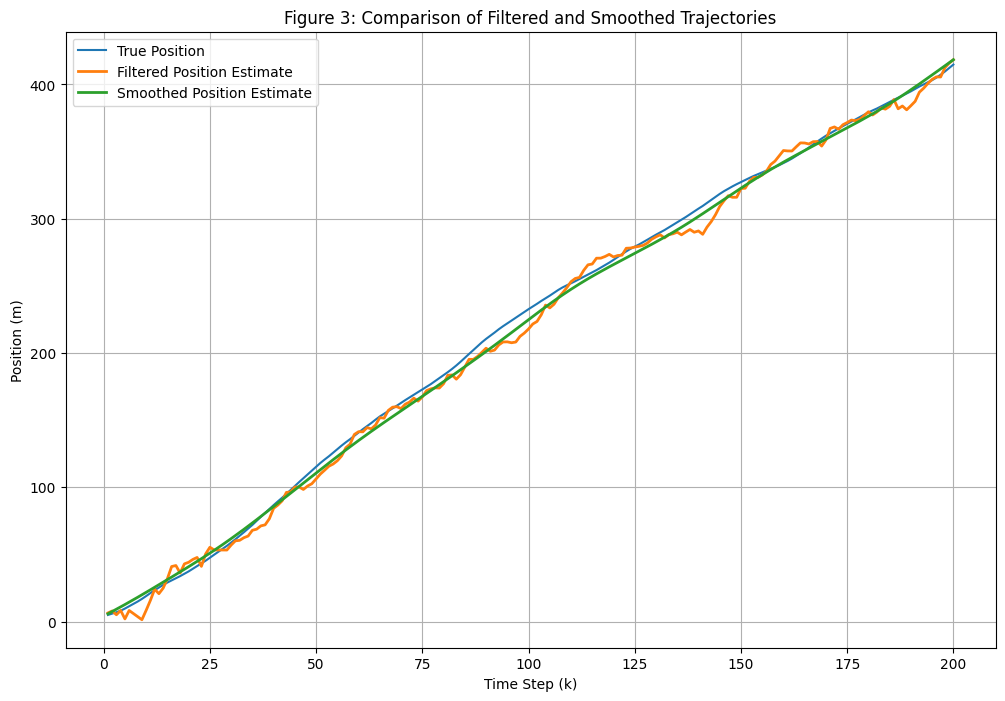

In [47]:
def run_backward_smoother(X_filtered, P_filtered, X_predicted, P_predicted, Phi):
    N = X_filtered.shape[0]
    X_smoothed = np.zeros_like(X_filtered)
    P_smoothed = np.zeros_like(P_filtered)
    
    X_smoothed[N-1] = X_filtered[N-1]
    P_smoothed[N-1] = P_filtered[N-1]
    
    for k in range(N - 2, -1, -1):
        P_pred_k_plus_1 = P_predicted[k+1]
        
        A_k = P_filtered[k] @ Phi.T @ np.linalg.inv(P_pred_k_plus_1)
        X_smoothed[k] = X_filtered[k] + A_k @ (X_smoothed[k+1] - X_predicted[k+1])
        P_smoothed[k] = P_filtered[k] + A_k @ (P_smoothed[k+1] - P_pred_k_plus_1) @ A_k.T
        
    return X_smoothed, P_smoothed

X_smoothed, P_smoothed= run_backward_smoother(X_filtered, P_filtered, X_predicted, P_predicted, Phi)

plt.figure(figsize=(12, 8))
plt.plot(range(1, N + 1), X_true[:, 0], label='True Position')
plt.plot(range(1, N + 1), X_filtered[:, 0], lw=2, label='Filtered Position Estimate')
plt.plot(range(1, N + 1), X_smoothed[:, 0], lw=2, label='Smoothed Position Estimate')
plt.title('Figure 3: Comparison of Filtered and Smoothed Trajectories')
plt.xlabel('Time Step (k)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Error Analysis

To robustly evaluate and compare the performance of the filter and the smoother, we run a simulation with `M = 500` runs. 

In [48]:
error_filter_pos = np.zeros((M, N))
error_filter_vel = np.zeros((M, N))
error_smooth_pos = np.zeros((M, N))
error_smooth_vel = np.zeros((M, N))

var_filter_pos = np.zeros((M, N))
var_filter_vel = np.zeros((M, N))
var_smooth_pos = np.zeros((M, N))
var_smooth_vel = np.zeros((M, N))

for m in range(M):
    X_true, z = generate_trajectory_and_measurements(N, X1_true, Phi, G, H, sigma_a_sq, sigma_eta_val_sq)
    
    X_filtered, P_filtered, X_predicted, P_predicted, _ = run_kalman_filter(z, N, sigma_a_sq, X0_0, P0_0)
        
    X_smoothed, P_smoothed = run_backward_smoother(X_filtered, P_filtered, X_predicted, P_predicted, Phi)
    
    error_filter_pos[m, :] = (X_filtered[:, 0] - X_true[:, 0]).flatten()
    error_filter_vel[m, :] = (X_filtered[:, 1] - X_true[:, 1]).flatten()
    error_smooth_pos[m, :] = (X_smoothed[:, 0] - X_true[:, 0]).flatten()
    error_smooth_vel[m, :] = (X_smoothed[:, 1] - X_true[:, 1]).flatten()
    
    var_filter_pos[m, :] = P_filtered[:, 0, 0].flatten()
    var_filter_vel[m, :] = P_filtered[:, 1, 1].flatten()
    var_smooth_pos[m, :] = P_smoothed[:, 0, 0].flatten()
    var_smooth_vel[m, :] = P_smoothed[:, 1, 1].flatten()

# True RMSE
rmse_filter_pos = np.sqrt(np.mean(error_filter_pos**2, axis=0))
rmse_filter_vel = np.sqrt(np.mean(error_filter_vel**2, axis=0))
rmse_smooth_pos = np.sqrt(np.mean(error_smooth_pos**2, axis=0))
rmse_smooth_vel = np.sqrt(np.mean(error_smooth_vel**2, axis=0))

# Calculated Deviation
std_calc_filter_pos = np.sqrt(np.mean(var_filter_pos, axis=0))
std_calc_filter_vel = np.sqrt(np.mean(var_filter_vel, axis=0))
std_calc_smooth_pos = np.sqrt(np.mean(var_smooth_pos, axis=0))
std_calc_smooth_vel = np.sqrt(np.mean(var_smooth_vel, axis=0))

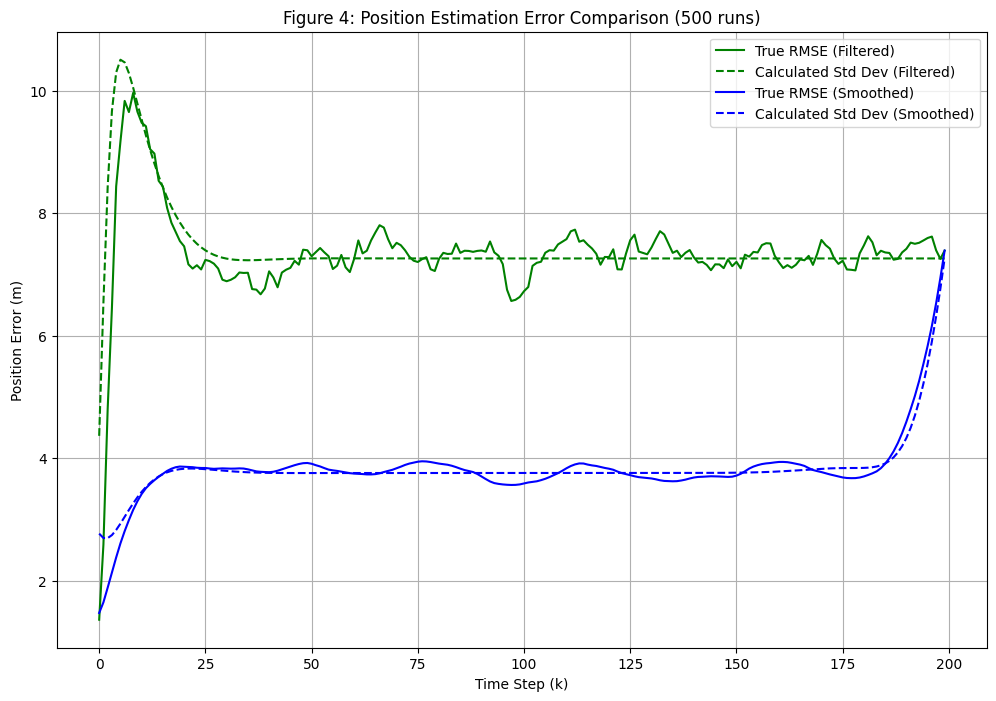

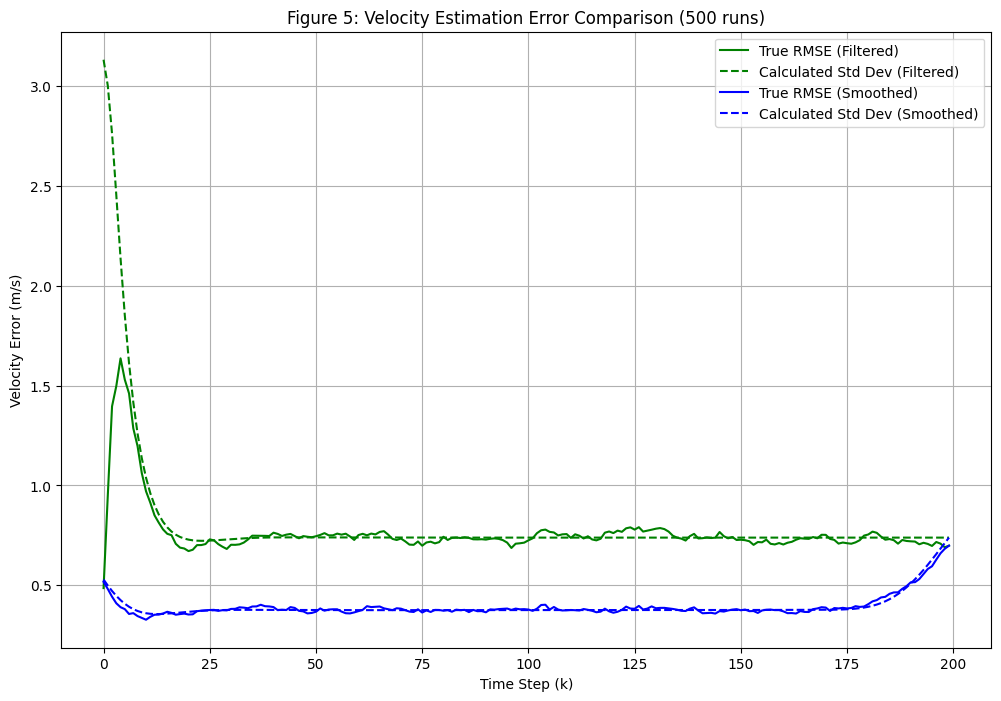

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(rmse_filter_pos, 'g-', label='True RMSE (Filtered)')
plt.plot(std_calc_filter_pos, 'g--', label='Calculated Std Dev (Filtered)')
plt.plot(rmse_smooth_pos, 'b-', label='True RMSE (Smoothed)')
plt.plot(std_calc_smooth_pos, 'b--', label='Calculated Std Dev (Smoothed)')
plt.title('Figure 4: Position Estimation Error Comparison (500 runs)')
plt.xlabel('Time Step (k)')
plt.ylabel('Position Error (m)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(rmse_filter_vel, 'g-', label='True RMSE (Filtered)')
plt.plot(std_calc_filter_vel, 'g--', label='Calculated Std Dev (Filtered)')
plt.plot(rmse_smooth_vel, 'b-', label='True RMSE (Smoothed)')
plt.plot(std_calc_smooth_vel, 'b--', label='Calculated Std Dev (Smoothed)')
plt.title('Figure 5: Velocity Estimation Error Comparison (500 runs)')
plt.xlabel('Time Step (k)')
plt.ylabel('Velocity Error (m/s)')
plt.legend()
plt.grid(True)
plt.show()

As shown in Figure 4 and Figure 5, the true RMSE for both position and velocity is significantly (almost twise) lower for the smoothed estimates. The filter's error reaches a steady state after several steps, whereas the smoother's error is lowest in the middle of the trajectory, benefiting from information from both past and future measurements.

The calculated deviation (from the covariance matrices) closely matches the "True RMSE" for both the filter and the smoother. This confirms that the covariance matrices are reliable indicators of the actual estimation uncertainty.

## 6. Learning Log

- Filtering is a real-time process that estimates the current state using only past and present data. Smoothing is an offline process that estimates the state at a given time `k` using the entire dataset. This access to "future" data (`t > k`) is what allows the smoother to achieve higher accuracy.

- The backward pass is a correction step that propagates information from the future back through the filtered estimates.

- Running a single simulation can be misleading due to random noise. The RMSE analysis with many trials is essential for validating the algorithms. It smooths out the randomness and provides a clear statistical picture of performance. It also validates that the mathematical model accurately reflects the real performance (the RMSE).

- If we need an answer "now", we must use a filter and accept its inherent uncertainty, but if we can wait until all data is collected, a smoother will provide a better result for the same underlying model.